In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib widget
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.features.breath_detection import BreathDetection
from eitprocessing.features.pixel_breath import PixelBreath
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.tidal_impedance_variation import TIV

MINUTE = 60

Load a sequence from file.

In [2]:
path = "/Users/juliettefrancovich/Documents/KT/TM3/eitprocessing/tests/test_data/Draeger_Test.bin"

In [3]:
sequence = load_eit_data(
    path,
    vendor="draeger",
)

Filter the global impedance using a low pass filter.

In [4]:
gi = sequence.continuous_data["global_impedance_(raw)"]

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)

sequence.continuous_data.add(
    ContinuousData(
        "global_impedance_(lowpass)",
        "Global impedance (low pass filtered)",
        "a.u.",
        "impedance",
        derived_from=[*gi.derived_from, gi],
        parameters={LowPassFilter: filter_params},
        time=gi.time,
        values=filter_.apply_filter(gi.values),
    ),
)

Filter pixel impedance

In [5]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

In [6]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance

filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)


filtered_pixel_impedance = filter_.apply_filter(pixel_impedance, axis=0)

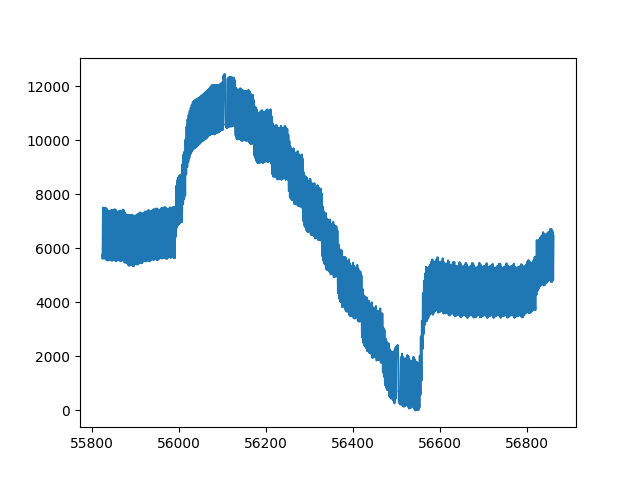

In [7]:
plt.figure()
plt.plot(sequence.eit_data["raw"].time, sequence.continuous_data["global_impedance_(raw)"])

Select a small portion of the sequence

In [8]:
sequence = sequence.t[55940:55970]

Breath detection on global impedance

In [9]:
bd = BreathDetection()
breaths = bd.find_breaths(sequence.continuous_data["global_impedance_(raw)"])

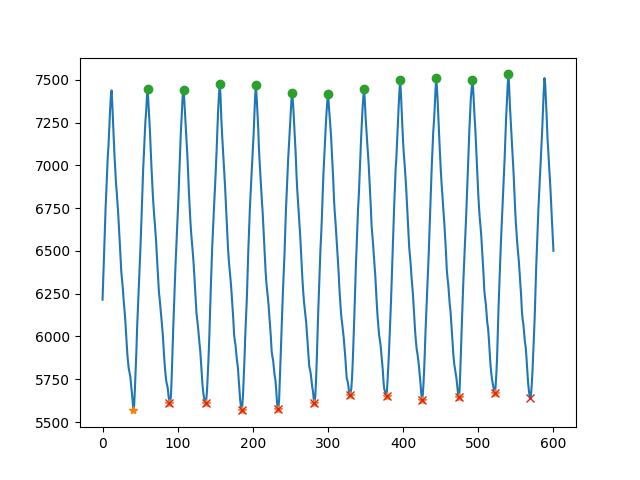

In [10]:
global_data = sequence.continuous_data["global_impedance_(raw)"].values

global_start_indices = [
    np.argmax(sequence.continuous_data["global_impedance_(raw)"].time == start_time)
    for start_time in [breath.start_time for breath in breaths.values]
]
global_middle_indices = [
    np.argmax(sequence.continuous_data["global_impedance_(raw)"].time == middle_time)
    for middle_time in [breath.middle_time for breath in breaths.values]
]
global_end_indices = [
    np.argmax(sequence.continuous_data["global_impedance_(raw)"].time == end_time)
    for end_time in [breath.end_time for breath in breaths.values]
]


plt.figure()
plt.plot(global_data)
plt.plot(global_start_indices, global_data[global_start_indices], "*")
plt.plot(global_middle_indices, global_data[global_middle_indices], "o")
plt.plot(global_end_indices, global_data[global_end_indices], "x")

Pixel breath detection on pixel impedance

In [11]:
pb = PixelBreath()
pixel_breaths = pb.find_pixel_breaths(
    eit_data=sequence.eit_data["raw"],
    continuous_data=sequence.continuous_data["global_impedance_(raw)"],
    sequence=sequence,
)

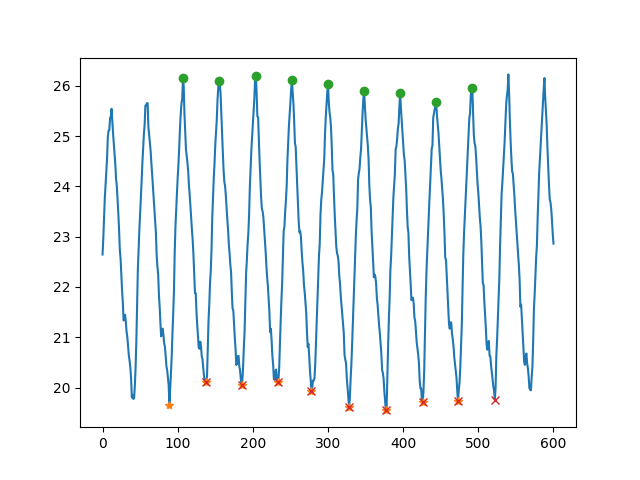

In [12]:
pixel_data = sequence.eit_data["raw"].pixel_impedance
pixel_breaths = np.stack(pixel_breaths.values)

# Handle None values
start_indices = [
    np.argmax(sequence.eit_data["raw"].time == start_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for start_time in [pixel_breath.start_time]
]

middle_indices = [
    np.argmax(sequence.eit_data["raw"].time == middle_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for middle_time in [pixel_breath.middle_time]
]

end_indices = [
    np.argmax(sequence.eit_data["raw"].time == end_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for end_time in [pixel_breath.end_time]
]


plt.figure()
plt.plot(pixel_data[:, 12, 13])
plt.plot(start_indices, pixel_data[start_indices, 12, 13], "*")
plt.plot(middle_indices, pixel_data[middle_indices, 12, 13], "o")
plt.plot(end_indices, pixel_data[end_indices, 12, 13], "x")

In [13]:
tiv_result_global_inspiratory = TIV().compute_continuous_parameter(sequence.continuous_data["global_impedance_(raw)"])
tiv_result_global_expiratory = TIV().compute_continuous_parameter(
    sequence.continuous_data["global_impedance_(raw)"],
    tiv_method="expiratory",
)
tiv_result_global_mean = TIV().compute_continuous_parameter(
    sequence.continuous_data["global_impedance_(raw)"],
    tiv_method="mean",
)
tiv_result_pixel_inspiratory = TIV().compute_pixel_parameter(
    sequence.eit_data["raw"],
    sequence.continuous_data["global_impedance_(raw)"],
    sequence,
    tiv_method="inspiratory",
    tiv_timing="pixel",
)
tiv_result_pixel_inspiratory_global_timing = TIV().compute_pixel_parameter(
    sequence.eit_data["raw"],
    sequence.continuous_data["global_impedance_(raw)"],
    sequence,
    tiv_method="inspiratory",
    tiv_timing="continuous",
)
tiv_result_pixel_expiratory = TIV().compute_pixel_parameter(
    sequence.eit_data["raw"],
    sequence.continuous_data["global_impedance_(raw)"],
    sequence,
    tiv_method="expiratory",
    tiv_timing="pixel",
)
tiv_result_pixel_mean = TIV().compute_pixel_parameter(
    sequence.eit_data["raw"],
    sequence.continuous_data["global_impedance_(raw)"],
    sequence,
    tiv_method="mean",
    tiv_timing="pixel",
)

Demonstrate TIV based on pixel breath timings

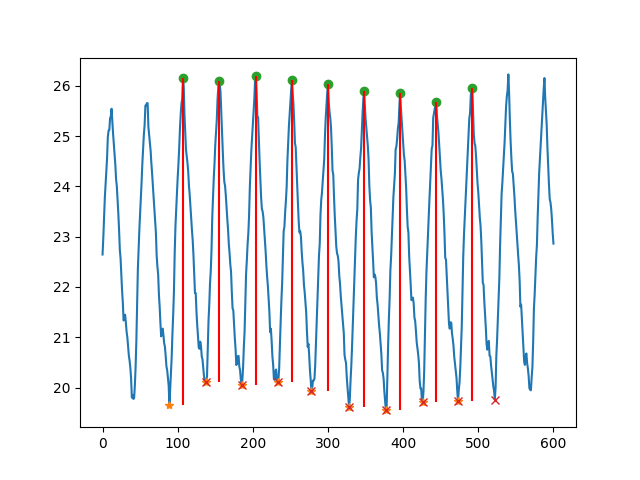

In [14]:
## Inspiratory TIV method
pixel_data = sequence.eit_data["raw"].pixel_impedance

start_indices = [
    np.argmax(sequence.eit_data["raw"].time == start_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for start_time in [pixel_breath.start_time]
]

middle_indices = [
    np.argmax(sequence.eit_data["raw"].time == middle_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for middle_time in [pixel_breath.middle_time]
]

end_indices = [
    np.argmax(sequence.eit_data["raw"].time == end_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for end_time in [pixel_breath.end_time]
]

plt.figure()
plt.plot(pixel_data[:, 12, 13])
plt.plot(start_indices, pixel_data[start_indices, 12, 13], "*")
plt.plot(middle_indices, pixel_data[middle_indices, 12, 13], "o")
plt.plot(end_indices, pixel_data[end_indices, 12, 13], "x")

# Plot vertical lines at middle_indices
for i, mid_idx in enumerate(middle_indices):
    plt.vlines(
        x=mid_idx,
        ymin=pixel_data[mid_idx, 12, 13] - tiv_result_pixel_inspiratory[i + 1, 12, 13],
        ymax=pixel_data[mid_idx, 12, 13],
        color="r",
        linestyle="-",
        label="TIV",
    )

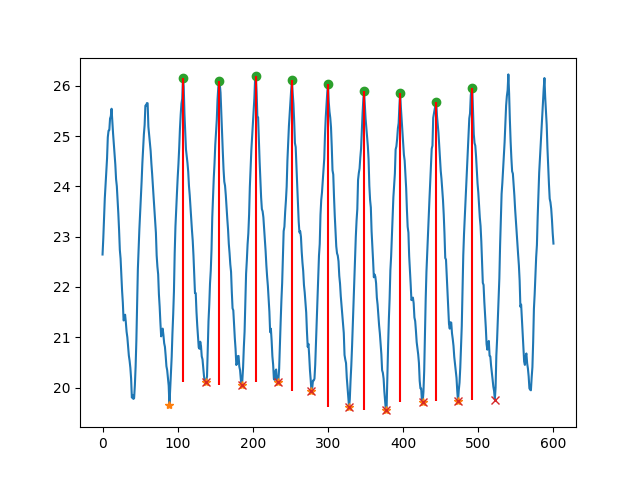

In [15]:
## Expiratory TIV method
pixel_data = sequence.eit_data["raw"].pixel_impedance

start_indices = [
    np.argmax(sequence.eit_data["raw"].time == start_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for start_time in [pixel_breath.start_time]
]

middle_indices = [
    np.argmax(sequence.eit_data["raw"].time == middle_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for middle_time in [pixel_breath.middle_time]
]

end_indices = [
    np.argmax(sequence.eit_data["raw"].time == end_time)
    for pixel_breath in pixel_breaths[:, 12, 13]
    if pixel_breath is not None
    for end_time in [pixel_breath.end_time]
]

plt.figure()
plt.plot(pixel_data[:, 12, 13])
plt.plot(start_indices, pixel_data[start_indices, 12, 13], "*")
plt.plot(middle_indices, pixel_data[middle_indices, 12, 13], "o")
plt.plot(end_indices, pixel_data[end_indices, 12, 13], "x")

# Plot vertical lines at middle_indices
for i, mid_idx in enumerate(middle_indices):
    plt.vlines(
        x=mid_idx,
        ymin=pixel_data[mid_idx, 12, 13] - tiv_result_pixel_expiratory[i + 1, 12, 13],
        ymax=pixel_data[mid_idx, 12, 13],
        color="r",
        linestyle="-",
        label="TIV",
    )

Demonstrate TIV based on global breaths timings

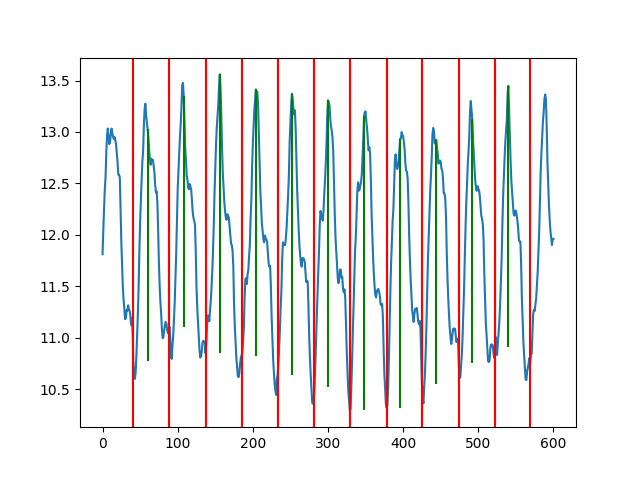

In [16]:
plt.figure()
plt.plot(pixel_data[:, 8, 8])

# tiv_result_shifted = tiv_result_pixel_inspiratory_global_timing[1:]
for i, glo_mid_idx in enumerate(global_middle_indices):
    plt.vlines(
        x=glo_mid_idx,
        ymin=pixel_data[glo_mid_idx, 8, 8] - tiv_result_pixel_inspiratory_global_timing[i, 8, 8],
        ymax=pixel_data[glo_mid_idx, 8, 8],
        color="g",
        linestyle="-",
        label="TIV",
    )

for i in range(len(global_start_indices)):
    plt.axvline(global_start_indices[i], color="red")
    plt.axvline(global_end_indices[i], color="red")

In [17]:
mean_tiv_map_inspiratory = np.nanmean(tiv_result_pixel_inspiratory, axis=0)
mean_tiv_map_expiratory = np.nanmean(tiv_result_pixel_expiratory, axis=0)
mean_tiv_map_mean = np.nanmean(tiv_result_pixel_mean, axis=0)
mean_tiv_map_inspiratory_cd_timing = np.nanmean(tiv_result_pixel_inspiratory_global_timing, axis=0)

/var/folders/m6/wsm3_cgd0fx7zkm_j_sph5s00000gn/T/ipykernel_14456/819553298.py:1: RuntimeWarning: Mean of empty slice
  mean_tiv_map_inspiratory = np.nanmean(tiv_result_pixel_inspiratory, axis=0)
/var/folders/m6/wsm3_cgd0fx7zkm_j_sph5s00000gn/T/ipykernel_14456/819553298.py:2: RuntimeWarning: Mean of empty slice
  mean_tiv_map_expiratory = np.nanmean(tiv_result_pixel_expiratory, axis=0)
/var/folders/m6/wsm3_cgd0fx7zkm_j_sph5s00000gn/T/ipykernel_14456/819553298.py:3: RuntimeWarning: Mean of empty slice
  mean_tiv_map_mean = np.nanmean(tiv_result_pixel_mean, axis=0)


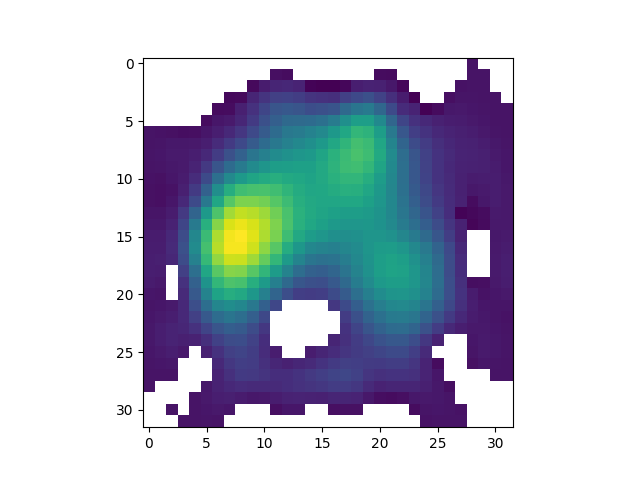

In [ ]:
plt.figure()
plt.imshow(mean_tiv_map_inspiratory)